In [2]:
"""
Created on Tue Dec  3 13:03:17 2024

@author: Marcin Plodzien
"""
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
import scipy.sparse as sp
import pandas as pd
import time
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
# Parameters
U = 1.0  # On-site interaction strength
neighbours_range = 1#L  # Cluster neighbor range
discard_simple_neighbours = False#True
max_cluster_size = None # None  # Set None for unrestricted cluster size
symmetry_breaking_field = 0*1e-9  # Small perturbation to break symmetry
max_iterations = 1 # Maximum iterations for self-consistency
tolerance = 1e-5 # Convergence tolerance
initial_phi = 1e-3

In [3]:
from scipy.sparse import lil_matrix, csr_matrix
import pickle
import joblib
#Generate basis
"""
from tempfile import mkdtemp
savedir = mkdtemp()
import os
file_vList = os.path.join(savedir, 'vList.joblib')
file_vDic = os.path.join(savedir, 'vDic.joblib')
"""
def generate_flucs_rec(M, f, value_range, target_sum, current_vector=None, index=0, current_sum=0, current_abs_sum=0):
    """This function returns all possible combinations of vectors of length M with values in value_range, so that:
    -The sum(abs(vector))<=f
    -The sum(vector) == target_sum
    (written by chatGPT but tested somewhat)
    """

    if current_vector is None:
        current_vector = [0] * M  # Initialize vector with zeros

    # Base case: If we have filled the vector, check the conditions
    if index == M:
        if current_sum == target_sum and current_abs_sum <= f:
            yield np.array(current_vector)
        return

    # Explore all possible values from the given range
    for value in value_range:
        new_sum = current_sum + value
        new_abs_sum = current_abs_sum + abs(value)

        # Prune invalid branches early
        if abs(new_sum - target_sum) > max(value_range) * (M - index - 1):  # Remaining positions cannot balance `target_sum`
            continue
        if new_abs_sum > f:  # Absolute sum constraint violated
            continue

        # Update the current vector and recurse
        current_vector[index] = value
        yield from generate_flucs_rec(M, f, value_range, target_sum, current_vector, index + 1, new_sum, new_abs_sum)
        current_vector[index] = 0  # Backtrack


def gen_full_basis_faster(M, max_global_flucs=5, filling=1, max_loc_flucs=2,N_minus=-2,N_plus=3):
    if type(filling) is not int: print("filling needs to be an integer")

    v0 = filling*np.ones(M,dtype=int)
    vRange = range(max(-max_loc_flucs, -filling), max_loc_flucs+1)

    N_vLists_1 = [np.array(list((generate_flucs_rec(M,max_global_flucs,vRange,N_diff)))) for N_diff in range(N_minus,N_plus + 1)]
    N_vLists = []
    for vL in N_vLists_1:
        if len(vL)>0: N_vLists.append(vL)
    vList=np.vstack(tuple(N_vLists))
    vList += v0

    def baseDict(vList):
        d = {}
        for idx,v in enumerate(vList):
            d[tuple(v)] = idx
        return d

    vDic = baseDict(vList)

    return vList, vDic

#Generate Hamiltonian components

def gen_H_kin_over_J(adMat,vList,vDic):
    
    xs, ys = adMat.nonzero()
    ham_kin = lil_matrix((vList.shape[0],vList.shape[0]))
    for i in range(vList.shape[0]):
        v = vList[i]
        for x,y in np.transpose([xs,ys]):
            if x!=y and v[y]>0:
                newV = v.copy()
                newV[x] += 1
                newV[y] -= 1
                tup = tuple(newV)
                if tup in vDic:
                    newIdx = vDic[tup]
                    ham_kin[i,newIdx] = -1*np.sqrt((v[x]+1)*v[y]) #J=1
    return ham_kin.tocsr()

def gen_H_int(vList):
    ham_int_U = lil_matrix((vList.shape[0],vList.shape[0]))
    for i in range(vList.shape[0]):
        v = vList[i]
        ham_int_U[i,i] = U/2*np.sum((v-1)*v) 
    return ham_int_U.tocsr()
def gen_H_chem_over_mu(vList):
    ham_chem = lil_matrix((vList.shape[0],vList.shape[0]))
    for i in range(vList.shape[0]):
        v = vList[i]
        ham_chem[i,i] = - 1*np.sum(v) #mu=1
    return ham_chem.tocsr()
def gen_H_MF_homogenous(J,niu,phi,vList,vDic,return_separately=True):
    #J = 1
    ham_MFbase = lil_matrix((vList.shape[0],vList.shape[0]))
    ham_MFconj = lil_matrix((vList.shape[0],vList.shape[0]))
    for site_idx, site_niu in enumerate(niu):
        if site_niu==0: pass
        else:
            for i in range(vList.shape[0]):
                v = vList[i]

                #add particle from bulk
                newV = v.copy()
                newV[site_idx] += 1
                
                tup = tuple(newV)
                if tup in vDic: #check if new state is included in our basis
                    newIdx = vDic[tup]
                    ham_MFbase[i,newIdx] = -J*site_niu*np.sqrt((v[site_idx]+1))*phi

                #remove particle from bulk
                newV = v.copy()
                newV[site_idx] -= 1

                tup = tuple(newV)
                if tup in vDic:
                    newIdx = vDic[tup]
                #if abs(np.sum(newV)-N)<=1:
                    ham_MFconj[i,newIdx] = -J*site_niu*np.sqrt((v[site_idx]))*np.conj(phi)
    if return_separately: return ham_MFbase.tocsr(),ham_MFconj.tocsr()
    else: return (ham_MFbase+ham_MFconj).tocsr()

#Calculate phi

def phi_at_site_t_fn(vList,vDic, gs, t):
    phi =  0
    fn = 0
    flucsum = 0
    fnsq = 0
    for i in range(vList.shape[0]):
        v = vList[i]
        Cn = gs[i]

        fn += Cn*np.conj(Cn)*np.sum(v)
        #flucsum += Cn*np.conj(Cn)*(np.sum(np.abs(v-1)))

        Dfn = Cn*np.conj(Cn)*np.sum(v)
        fnsq += Dfn*np.sum(v)
        #if Cn*np.conj(Cn)>0.001: #DEBUG
        #    print(f'{Cn*np.conj(Cn):.4f} {v} {np.sum(np.abs(v-1))}')
        if v[t] == 0 or Cn==0:
            continue
        
        newV = v.copy()
        newV[t] -= 1
        
        tup = tuple(newV)
        if tup in vDic:
            newIdx = vDic[tup]
            Cm = np.conj(gs[newIdx])
            phi += Cm*Cn*np.sqrt(v[t])
    return phi, fn, fnsq-(fn**2) #or change to flucsum

def homogenous_cluster_calculate_phi_H_tuple(mu, J, H_tuple_mu1_J1, target_node, 
                                             serialized_vList, serialized_vDic, serialized_basis=True
                                             , max_iterations=max_iterations, return_fn = True):
    # Calculate the superfluid order parameter phi for a given chemical potential mu and hopping parameter J
    # using the Hamiltonian components provided in H_tuple_mu1_J1 (to not generate them every time)

    if serialized_basis:
        #serialize if running in parallel processes
        vList = pickle.loads(serialized_vList)
        vDic = pickle.loads(serialized_vDic)
    else:
        vList = serialized_vList
        vDic = serialized_vDic
    start_time = time.time()#

    h_kin_o_J, h_int, h_chem_o_mu, H_MF_phi1_tup = H_tuple_mu1_J1
    H_inside = J*h_kin_o_J + h_int + mu*h_chem_o_mu
    #if len(niu) != len(vList[0]): print(f'error: niu len {len(niu)} =/= size {len(vList[0])}')
    phi = initial_phi
    for iteration in range(max_iterations):
        phi_old = phi
        
        start_time = time.time()#

        H_MF_phi1_base, H_MF_phi1_conj = H_MF_phi1_tup
        H_MF = J*phi*H_MF_phi1_base + J*np.conj(phi)*H_MF_phi1_conj
        H_C = H_inside + H_MF

        #For benchmarking the time per 1 point:
        print(f"1 {time.time() - start_time:.2f} seconds")#
        eigenvalues, eigenvectors = eigsh(H_C,k=1,which='SA')#,v0 = GS_guess)
        print(f"2 {time.time() - start_time:.2f} seconds")#
        print(f"Energy = {eigenvalues[0]} (mu {mu}, J {J})") 
        ground_state = eigenvectors[:, 0]
        ground_state /= np.linalg.norm(ground_state)
        GS_guess = ground_state
        # Compute superfluid order parameter
        print(f"2.5 {time.time() - start_time:.2f} seconds")#
        phi, fn, flucsum = phi_at_site_t_fn(vList, vDic, ground_state, target_node)
        print(f"3 {time.time() - start_time:.2f} seconds")
        
        # Check convergence
        max_phi_diff = abs(phi - phi_old)
        if max_phi_diff < tolerance:
            #print(f"Converged after {iteration + 1} iterations")
            break
    phase_diagram_superfluid_mu_J = abs(phi)
    if return_fn: return phase_diagram_superfluid_mu_J, fn, flucsum
    return phase_diagram_superfluid_mu_J#, ground_state

In [4]:
#For finding just the MI/SF boundary

from scipy.optimize import bisect
def find_critical_J_H_tuple(mu,h_tup,basis_tup,target_node,crit_phi = initial_phi,max_J=0.1,xtol=1e-5,serialized_basis=True):
    #finds the t/U at which avg(phi) = crit_phi, for a given mu
    def f(J):
        #we sometimes get a false MI phase because of basis truncation
        #ideally this should be modified to detect the false MI using return_fn=True and looking at fn or flucsum

        return homogenous_cluster_calculate_phi_H_tuple(mu, J, h_tup, target_node, *basis_tup, return_fn=False, serialized_basis=serialized_basis)-crit_phi
    
    print(f"mu={mu}, f(0)={f(0)} vs {f(max_J)}, crit {crit_phi}")
    try:
        return bisect(f,0,max_J,xtol=xtol)
    except Exception as error:
        print("An exception occurred:", error)
        return 0


def lobe_dataParallel_H_tuple(G,target_node,niu_expected_edges,crit_phi = initial_phi,max_J=0.1,xtol=1e-5,mu_min=0,mu_max=1,
                      point_number=100, parallel=True, max_global_flucs=5, N_minus=-1, N_plus=+3):
    #finds the t/U at which avg(phi) = crit_phi, for a point_number values of mu between mu_min and mu_max
    
    print(f'Starting calculation for {point_number} points of a size {G.number_of_nodes()} sites')
    start_time = time.time()
    
    eps = 0*1e-4
    mu_values = np.linspace(mu_min+eps, mu_max-eps, point_number)

    adj_mat = nx.adjacency_matrix(G)
    neib_num = np.sum(adj_mat.todense(),axis=0)
    niu = niu_expected_edges - neib_num
    niu = np.maximum(niu, 0) #in case we want niu less than inside the cluster
    
    #Generate the basis
    st = time.time()

    M = adj_mat.shape[0]
    basis_tup = gen_full_basis_faster(M, max_global_flucs=max_global_flucs, N_minus=N_minus, N_plus=N_plus)
    print(f"Basis of size {len(basis_tup[0])} generated in {time.time() - st:.4f} s")
    
    vList = basis_tup[0]
    
    #Generate the Hamiltonian components with parameters J, mu, phi equal to 1 (U in h_int has the global U value)
    st = time.time()
    
    h_kin_o_J =  gen_H_kin_over_J(adj_mat,*basis_tup)
    h_int = gen_H_int(vList)
    h_chem_o_mu = gen_H_chem_over_mu(vList)
    H_MF_tup = gen_H_MF_homogenous(1,niu,1,*basis_tup,return_separately=True)
    
    H_tuple_mu1_J1 = h_kin_o_J, h_int, h_chem_o_mu, H_MF_tup

    print(f"H of size {h_int.shape[0]} generated in {time.time() - st:.4f} s")
    J = 0.02
    mu = 0.99
    H_inside = J*h_kin_o_J + h_int + mu*h_chem_o_mu
    phi = initial_phi
    H_MF_phi1_base, H_MF_phi1_conj = H_MF_tup
    H_MF = J*phi*H_MF_phi1_base + J*np.conj(phi)*H_MF_phi1_conj
    H_C = H_inside + H_MF
    st = time.time()
    test = eigsh(H_C,k=1,which='SA')
    print(f"H of size {H_C.shape[0]} solved in {time.time() - st:.4f} s")
    #. phi {phi_at_site_t(*basis_tup, test[0][:, 0], target_node)}")
    st = time.time()
    test2, fn, flucsum = homogenous_cluster_calculate_phi_H_tuple(mu, J, H_tuple_mu1_J1, target_node, *basis_tup, serialized_basis=False)
    print(f"Phi calculated in  {time.time() - st:.4f} s, phi = {test2}, <N> = {fn}, flucsum = {flucsum}")
    if parallel:
        serialized_vList = pickle.dumps(basis_tup[0])
        serialized_vDic = pickle.dumps(basis_tup[1])
        ser_basis = serialized_vList, serialized_vDic
        J_c_values = Parallel(n_jobs=-1)(delayed(find_critical_J_H_tuple)(mu,H_tuple_mu1_J1,ser_basis,target_node,crit_phi=crit_phi,max_J=max_J,xtol=xtol) for mu in tqdm(mu_values, desc="Processing", leave=True))
    else:
        J_c_values = [find_critical_J_H_tuple(mu,H_tuple_mu1_J1,basis_tup,target_node,crit_phi=crit_phi,max_J=max_J,xtol=xtol,serialized_basis=False) for mu in tqdm(mu_values, desc="Processing", leave=True)]

    end_time = time.time()
    print(f"Calculation completed in {end_time - start_time:.2f} seconds")

    return mu_values, J_c_values


In [5]:
#For generating the phase diagram MI/SF(J,mu)
#single cluster connected to the mean field with the same phi at each boundary site

import csv
import os

def phaseDiagramDataParallel_H_tuple(G,target_node,niu_expected_edges,max_J=0.1,mu_min=0,mu_max=1,
                      point_number=100, point_number_J=None,parallel=True, max_global_flucs=5, max_loc_flucs=2,J_min=0,max_iterations=50, 
                      N_minus=-1, N_plus=+3, save_csv_path=None):
    #G - graph to be used as a cluster
    #target_node - node where we calculate the order parameter
    #niu_expected_edges - number of expected edges in the cluster
    #max_global/local_flucs, N_minus/N_plus - parameters for the basis generation (truncation)



    print(f'Starting calculation for {point_number} points of a size {G.number_of_nodes()} sites')
    start_time = time.time()
    if point_number_J is None:
        point_number_J = point_number
    eps = 0*1e-4
    mu_values = np.linspace(mu_min+eps, mu_max-eps, point_number)
    J_values = np.linspace(J_min, max_J, point_number_J)

    adj_mat = nx.adjacency_matrix(G)
    neib_num = np.sum(adj_mat.todense(),axis=0)
    niu = niu_expected_edges - neib_num
    niu = np.maximum(niu, 0) #if niu less than inside the cluster, we avoid negative niu
    
    #Generate the basis
    st = time.time()

    M = adj_mat.shape[0]
    basis_tup = gen_full_basis_faster(M, max_global_flucs=max_global_flucs, max_loc_flucs=max_loc_flucs, N_minus=N_minus, N_plus=N_plus)
    print(f"Basis of size {len(basis_tup[0])} generated in {time.time() - st:.4f} s")

    
    vList = basis_tup[0]

    #Generate the Hamiltonian components with parameters J, mu, phi equal to 1 (U in h_int has the global U value)
    st = time.time()
    
    h_kin_o_J =  gen_H_kin_over_J(adj_mat,*basis_tup)
    h_int = gen_H_int(vList)
    h_chem_o_mu = gen_H_chem_over_mu(vList)
    H_MF_tup = gen_H_MF_homogenous(1,niu,1,*basis_tup,return_separately=True)
    
    H_tuple_mu1_J1 = h_kin_o_J, h_int, h_chem_o_mu, H_MF_tup

    print(f"H of size {h_int.shape[0]} generated in {time.time() - st:.4f} s")
    """
    #For testing:
    J = 0.02
    mu = 0.99
    H_inside = J*h_kin_o_J + h_int + mu*h_chem_o_mu
    phi = initial_phi
    H_MF_phi1_base, H_MF_phi1_conj = H_MF_tup
    H_MF = J*phi*H_MF_phi1_base + J*np.conj(phi)*H_MF_phi1_conj
    H_C = H_inside + H_MF
    st = time.time()
    test = eigsh(H_C,k=1,which='SA')
    print(f"H of size {H_C.shape[0]} solved in {time.time() - st:.4f} s")
    #. phi {phi_at_site_t(*basis_tup, test[0][:, 0], target_node)}")
    st = time.time()
    test2, fn, flucsum = homogenous_cluster_calculate_phi_H_tuple(mu, J, H_tuple_mu1_J1, target_node, *basis_tup,serialized_basis=False)
    print(f"Phi calculated in  {time.time() - st:.4f} s, phi = {test2}, <N> = {fn}, flucsum = {flucsum}")
    """
    #
    mu_J_zipped = []
    for mu in mu_values:
        for J in J_values:
            mu_J_zipped.append((mu,J))
    if save_csv_path is not None:
        headers = ["J", "mu", "phi", "<n>", "<dN^2>"]
        
        if not os.path.exists(save_csv_path+'.csv'):
            with open(save_csv_path+'.csv', mode="w", newline="") as file:
                writer = csv.writer(file)
                writer.writerow(headers)
        results = []

        #serialize the basis for parallelization
        serialized_vList = pickle.dumps(basis_tup[0])
        serialized_vDic = pickle.dumps(basis_tup[1])
        ser_basis = serialized_vList, serialized_vDic
        
        # Save the results to a CSV file after each J "row"
        for J in tqdm(J_values, desc="Processing", leave=True):
            r_J = Parallel(n_jobs=-1)(delayed(homogenous_cluster_calculate_phi_H_tuple)(mu, J, H_tuple_mu1_J1, target_node, *ser_basis,max_iterations=max_iterations) for mu in mu_values)
            
            results.append(r_J)
            
            
            phi_list = [r[0] for r in r_J]
            fn_list = [r[1] for r in r_J]
            flucsum_list = [r[2] for r in r_J]

            with open(save_csv_path + '.csv', 'a') as f_object:
 
                writer_object = csv.writer(f_object)
                for i,mu in enumerate(mu_values):
                    l = [J, mu, phi_list[i], fn_list[i], flucsum_list[i]]
                    writer_object.writerow(l)
            
                f_object.close()
        results = list(map(list, zip(*results))) #transpose 
        results = [item for sublist in results for item in sublist]#and flatten for consistency
    elif parallel:
        #if we dont save to csv, we can parallelize each point
        serialized_vList = pickle.dumps(basis_tup[0])
        serialized_vDic = pickle.dumps(basis_tup[1])
        ser_basis = serialized_vList, serialized_vDic

        # DEBUG options: #require='sharedmem' #prefer="threads"
        results = Parallel(n_jobs=-1)(delayed(homogenous_cluster_calculate_phi_H_tuple)(mu, J, H_tuple_mu1_J1, target_node, *ser_basis, max_iterations=max_iterations) 
                                      for mu,J in tqdm(mu_J_zipped, desc="Processing", leave=True))
    else:
        #not parallelized
        results = [homogenous_cluster_calculate_phi_H_tuple(mu, J, H_tuple_mu1_J1, target_node, *basis_tup,max_iterations=max_iterations,serialized_basis=False) for mu in tqdm(mu_values, desc="Processing", leave=True) for J in J_values]
    # Reshape the results into a 2D array (phase diagram)
    phi_avg_values = np.array([r[0] for r in results]).reshape(len(mu_values), len(J_values)).T
    fn_avg_values = np.array([r[1] for r in results]).reshape(len(mu_values), len(J_values)).T
    flucsum_avg_values = np.array([r[2] for r in results]).reshape(len(mu_values), len(J_values)).T
    
    end_time = time.time()
    print(f"Calculation completed in {end_time - start_time:.2f} seconds")
    return (J_values, mu_values, phi_avg_values, fn_avg_values, flucsum_avg_values)

In [6]:
#overlapping clusters functions
#each site has a cluster, which limits cluster size
#discard_simple_neighbours, neighbours_range and max_cluster_size are used to control the cluster shape and size

def find_MF_overlapping(G, cluster_nodes, phi_C):
    #this function checks each node in cluster_nodes and looks if it is connected to nodes from other clusters
    #phi_C[neighbour] is summed over neigbours from outside the considered cluster  
    ###IMPORTANT: it assumes that every node in G has it's own cluster
    #(alternate approach needed for generalization)

    Phi_cluster_list = np.zeros(len(cluster_nodes), dtype=np.complex128)
    for i,node in enumerate(cluster_nodes):
        neighbours = list(G.neighbors(node))
        #check every neighbor if it is inside our cluster
        for nbr in neighbours:
            if nbr not in cluster_nodes:
                if nbr in phi_C:
                    Phi_cluster_list[i] += phi_C[nbr]
                else:
                    print(f'Error: neighbour {nbr} of site {node} does not have its own cluster')
            #else: Phi_cluster_list[i] += phi_C[nbr]*1 #debug
    return Phi_cluster_list

def gen_H_MF_frame_overlap(J,vList,vDic,return_separately=True):
    #this will construct a MF hamiltonian of a cluster, but will return separately
    #-J*sqrt(n+1)... matrix and a placeholder matrix of phi. One needs to multiply the two element wise.
    #the placeholder matrix will have integer values (x) that need to be substituted with the MF value at site x
    #additionally we return the <a> and <a^dag> part separately
    #this needs to be done because constructing these matrices is computationally heavy.
    ham_MFbase_scalar = lil_matrix((vList.shape[0],vList.shape[0]))
    ham_MFbase_placeholder = lil_matrix((vList.shape[0],vList.shape[0]))
    ham_MFconj_scalar = lil_matrix((vList.shape[0],vList.shape[0]))
    ham_MFconj_placeholder = lil_matrix((vList.shape[0],vList.shape[0]))
    for site_idx in range(len(vList[0])):
        for i in range(vList.shape[0]):
            v = vList[i]

            #add particle from bulk
            newV = v.copy()
            newV[site_idx] += 1

            tup = tuple(newV)
            if tup in vDic:
                newIdx = vDic[tup]
                ham_MFbase_scalar[i,newIdx] = -J*np.sqrt((v[site_idx]+1))
                ham_MFbase_placeholder[i,newIdx] = site_idx+1

            #remove particle from bulk
            newV = v.copy()
            newV[site_idx] -= 1
            tup = tuple(newV)
            if tup in vDic:
                newIdx = vDic[tup]
                ham_MFconj_scalar[i,newIdx] = -J*np.sqrt((v[site_idx]+1))
                ham_MFconj_placeholder[i,newIdx] = site_idx+1
    if return_separately: 
        return (ham_MFbase_scalar.tocsr(), ham_MFbase_placeholder.tocsr()),(ham_MFconj_scalar.tocsr(), ham_MFconj_placeholder.tocsr())
    else: return (ham_MFbase_scalar+ham_MFconj_scalar).tocsr(), ham_MFbase_placeholder, ham_MFconj_placeholder

def initialize_clusters(G, neighbours_range, max_cluster_size=None):
    clusters = {}
    cluster_info = []
    cluster_adj_matrices = {}

    for node in G.nodes():
        # Handle the special case where neighbours_range = 0
        if neighbours_range == 0:
            cluster_nodes = [node]
        else:
            # Find neighbors within the specified range
            cluster_nodes = set()
            for dist in range(1, neighbours_range + 1):
                cluster_nodes.update(nx.single_source_shortest_path_length(G, node, cutoff=dist).keys())
            cluster_nodes = list(cluster_nodes)

        # Limit the cluster size if specified
        if max_cluster_size:
            cluster_nodes = cluster_nodes[:max_cluster_size]

        # Store the cluster in the dictionary
        clusters[node] = cluster_nodes

        # Compute cluster properties
        cluster_size = len(cluster_nodes)

        # Create a subgraph for the cluster and extract the adjacency matrix
        subgraph = G.subgraph(cluster_nodes)
        adj_matrix = nx.adjacency_matrix(subgraph).toarray()
        cluster_adj_matrices[node] = adj_matrix

        # Append information to the DataFrame
        cluster_info.append({
            "Central Node": node,
            "Cluster Nodes": cluster_nodes,
            "Cluster Size": cluster_size
        })

    # Create a pandas DataFrame from the cluster information
    cluster_df = pd.DataFrame(cluster_info)

    return clusters, cluster_df, cluster_adj_matrices

def combine_H_MF_tup(ham_MF_scalar, ham_MF_placeholder, felt_MF, conjugate=False):
    H_MF_combined = ham_MF_placeholder.copy()
    if conjugate:
        H_MF_combined.data = np.array([np.conj(felt_MF[int(x) - 1]) for x in H_MF_combined.data])
    else:
        H_MF_combined.data = np.array([felt_MF[int(x) - 1] for x in H_MF_combined.data])
    return ham_MF_scalar.multiply(H_MF_combined)

def overlap_cluster_calculate_phi_H_tuple(mu, J, cluster_H_tuples, G, clusters, basis_tup_dict, max_iterations=max_iterations, return_all_phis=False):
    
    #start_time = time.time()#
    
    #if len(niu) != len(vList[0]): print(f'error: niu len {len(niu)} =/= size {len(vList[0])}')
    randomize_phase = True
    if randomize_phase:
        phi_C = {node: initial_phi * np.exp(1j * np.random.uniform(0, 2 * np.pi)) for node in clusters} #phi at each site (assuming each site has a cluster) #with random complex phase
    else:
        phi_C = {node: initial_phi for node in clusters} #phi at each site (assuming each site has a cluster)
    for iteration in range(max_iterations):
        fillings = []
        fluctuations = []
        for node, cluster_nodes in clusters.items():

            H_tuple_mu1_J1 = cluster_H_tuples[node]
            h_kin_o_J, h_int, h_chem_o_mu, H_MF_phi1_tup = H_tuple_mu1_J1
            H_inside = J*h_kin_o_J + h_int + mu*h_chem_o_mu
            vList, Tsort, ind = basis_tup_dict[node]

            target_node = cluster_nodes.index(node)
            phi_C_old = phi_C.copy()

            H_MF_phi1_base_tup, H_MF_phi1_conj_tup = H_MF_phi1_tup

            #for each site inside the cluster, we sum the felt MF from neighboring sites that are outside of the considered cluster
            felt_MF_in_cluster = find_MF_overlapping(G,cluster_nodes,phi_C) 
            #we input the MF into our pre-constructed hamiltonians for efficiency (hopefully)
            H_MF_J1_base = combine_H_MF_tup(*H_MF_phi1_base_tup, felt_MF_in_cluster, conjugate=False)
            H_MF_J1_conj = combine_H_MF_tup(*H_MF_phi1_conj_tup, felt_MF_in_cluster, conjugate=True)

            H_MF = J*H_MF_J1_base + J*H_MF_J1_conj
            H_C = H_inside + H_MF

            eigenvalues, eigenvectors = eigsh(H_C,k=1,which='SA')#,v0 = GS_guess)
            ground_state = eigenvectors[:, 0]
            ground_state /= np.linalg.norm(ground_state)
            # Compute superfluid order parameter            
            phi, fn, flucsum = phi_at_site_t_fn(vList, Tsort, ind, ground_state, target_node)
            fillings.append(abs(fn)/len(cluster_nodes)) #calculate the average filling in each cluster
            fluctuations.append(flucsum/len(cluster_nodes)) #calculate the average fluctuation in each cluster

            phi_C[node] = phi
        # Check convergence
        max_phi_diff = max(abs(phi_C[node] - phi_C_old[node]) for node in clusters)
        if max_phi_diff < tolerance:
            print(f"Converged after {iteration + 1} iterations")
            break

    superfluid_order = np.mean([abs(phi_C[node]) for node in clusters])
    superfluid_average = np.mean([phi_C[node] for node in clusters])
    average_filling = np.mean(fillings)
    if return_all_phis: 
        print(f"energy in last cluster {eigenvalues}, fill {average_filling}")
        return phi_C
    return superfluid_order, average_filling, fluctuations, superfluid_average


def construct_clusters_hamiltonians(adj_mat, max_global_flucs, max_loc_flucs,N_minus=-2, N_plus=+3):
    M = adj_mat.shape[0]
    basis_tup = gen_full_basis_faster(M, max_global_flucs=max_global_flucs, max_loc_flucs=max_loc_flucs, N_minus=N_minus, N_plus=N_plus)  
    vList = basis_tup[0]

    #Generate the Hamiltonian components with parameters J, mu, phi equal to 1 (U in h_int has the global U value)
    h_kin_o_J =  gen_H_kin_over_J(adj_mat,*basis_tup)
    h_int = gen_H_int(vList)
    h_chem_o_mu = gen_H_chem_over_mu(vList)
    H_MF_tup = gen_H_MF_frame_overlap(1,*basis_tup,return_separately=True)
    H_tuple_mu1_J1 = h_kin_o_J, h_int, h_chem_o_mu, H_MF_tup
    return H_tuple_mu1_J1, basis_tup

def phaseDiagramDataParallel_overlap(G,max_J=0.1,mu_min=0,mu_max=1,point_number_J=None,
                      point_number=100, parallel=True, max_global_flucs=5, max_loc_flucs=2,J_min=0,max_iterations=50,neighbours_range=neighbours_range, parallel_gen_h=True, N_minus=-2, N_plus=+3, save_csv_path=None):
    
    print(f'Starting calculation for {point_number} points of a size {G.number_of_nodes()} sites')
    start_time = time.time()
    
    if point_number_J is None:
        point_number_J = point_number
    eps = 0*1e-4
    mu_values = np.linspace(mu_min+eps, mu_max-eps, point_number)
    J_values = np.linspace(J_min, max_J, point_number_J)

    #Construct clusters
    clusters, clusters_df, cluster_adj_matrices = initialize_clusters(G, neighbours_range, max_cluster_size)
    cluster_H_tuples = {}
    basis_tup_dict = {}
    print(clusters_df)
    #Generate the 'basic' hamiltonians for each cluster
    #to avoid constructing two same hamiltonians i make a list that on each index has a matrix or an int equal to the index of the first equivalent matrix
    debug_count = 0
    adj_mat_similarity_list = []
    unique_nodes = []
    for node, cluster_nodes in clusters.items():
        adj_mat = cluster_adj_matrices[node]
        found_similar_adj = -1
        for i,matrix in enumerate(adj_mat_similarity_list):
            if type(matrix) == int:
                continue #only check with the first appearance of any unique matrix
            if np.array_equal(adj_mat, matrix):
                found_similar_adj = i
                break
        if found_similar_adj<0:
            adj_mat_similarity_list.append(adj_mat)
            unique_nodes.append(node)
        else:
            adj_mat_similarity_list.append(found_similar_adj)
            debug_count+=1
    print(f'replaced {debug_count} matrices')
    
    if parallel_gen_h:
        unique_c_tuples = Parallel(n_jobs=-1)(delayed(construct_clusters_hamiltonians)(cluster_adj_matrices[node], max_global_flucs, max_loc_flucs, N_minus=N_minus, N_plus=N_plus) for node in tqdm(unique_nodes, desc="Generating hamiltonians", leave=True))
    else:
        unique_c_tuples = [construct_clusters_hamiltonians(cluster_adj_matrices[node], max_global_flucs, max_loc_flucs, N_minus=N_minus, N_plus=N_plus) for node in tqdm(unique_nodes, desc="Generating hamiltonians", leave=True)]
    
    uct_dict = dict(zip(unique_nodes, unique_c_tuples))
    i = 0
    nodes = []
    for node, cluster_nodes in clusters.items():
        nodes.append(node)
        adj_mat = adj_mat_similarity_list[i]
        if type(adj_mat) is not int:
            H_tuple_mu1_J1, basis_tup = uct_dict[node]#construct_clusters_hamiltonians(adj_mat, max_global_flucs, max_loc_flucs)
            cluster_H_tuples[node] = H_tuple_mu1_J1
            basis_tup_dict[node] = basis_tup
        else:
            cluster_H_tuples[node] = cluster_H_tuples[nodes[adj_mat]]
            basis_tup_dict[node] = basis_tup_dict[nodes[adj_mat]]
        i+=1
    mu_J_zipped = []
    for mu in mu_values:
        for J in J_values:
            mu_J_zipped.append((mu,J))

    
    if save_csv_path is not None:
        headers = ["J", "mu", "|phi|", "<n>", "<phi>"]
        
        if not os.path.exists(save_csv_path+'.csv'):
            with open(save_csv_path+'.csv', mode="w", newline="") as file:
                writer = csv.writer(file)
                writer.writerow(headers)
        results = []
        for J in tqdm(J_values, desc="Processing", leave=True):
            r_J = Parallel(n_jobs=-1)(delayed(overlap_cluster_calculate_phi_H_tuple)(mu, J, cluster_H_tuples, G, clusters, basis_tup_dict,max_iterations=max_iterations) for mu in mu_values)
            
            results.append(r_J)
            
            
            phi_list = [r[0] for r in r_J]
            fn_list = [r[1] for r in r_J]
            avg_phi_list = [r[2] for r in r_J]

            with open(save_csv_path + '.csv', 'a') as f_object:
 
                writer_object = csv.writer(f_object)
                for i,mu in enumerate(mu_values):
                    l = [J, mu, phi_list[i], fn_list[i], avg_phi_list[i]]
                    writer_object.writerow(l)
            
                f_object.close()
        results = list(map(list, zip(*results))) #transpose 
        results = [item for sublist in results for item in sublist]#and flatten for consistency
    elif parallel:
        results = Parallel(n_jobs=-1)(delayed(overlap_cluster_calculate_phi_H_tuple)(mu, J, cluster_H_tuples, G, clusters, basis_tup_dict,max_iterations=max_iterations) for mu,J in tqdm(mu_J_zipped, desc="Processing", leave=True))
    else:
        results = [overlap_cluster_calculate_phi_H_tuple(mu, J, cluster_H_tuples, G, clusters, basis_tup_dict,max_iterations=max_iterations) for mu in tqdm(mu_values, desc="Processing", leave=True) for J in J_values]
    # Reshape the results into a 2D array (phase diagram)
    phi_avg_values = np.array([r[0] for r in results]).reshape(len(mu_values), len(J_values)).T
    fn_avg_values = np.array([r[1] for r in results]).reshape(len(mu_values), len(J_values)).T
    flucsum_avg_values = np.array([r[2] for r in results]).reshape(len(mu_values), len(J_values)).T
    phi_exp_values = np.array([r[3] for r in results]).reshape(len(mu_values), len(J_values)).T
    
    end_time = time.time()
    print(f"Calculation completed in {end_time - start_time:.2f} seconds")
    return (J_values, mu_values, phi_avg_values, fn_avg_values, flucsum_avg_values, phi_exp_values)



In [7]:
def phaseDiagramPlotter(data, G, pos, title="", filepath=None,binarize=False, plot_phi_exp = True):
    
    if len(data) == 6:
        t_over_U_values, mu_values, phi_avg_values, fn_avg_values, flucsum_avg_values, phi_exp_values = data
        if plot_phi_exp: 
            fn_avg_values = [abs(ph) for ph in phi_exp_values] #this is what we want to plot
            third_title = "<|phi|>"
        else:
            third_title = "<n>"
        plots = 3
    if len(data) == 5:
        t_over_U_values, mu_values, phi_avg_values, fn_avg_values, flucsum_avg_values = data
        fn_avg_values = flucsum_avg_values #this is what we want to plot
        plots = 3
        third_title = "<$\Sigma |n_i - 1|$>"
    elif len(data) == 4:
        t_over_U_values, mu_values, phi_avg_values, fn_avg_values = data
        plots = 3
        third_title = "<N>"
    else:
        t_over_U_values, mu_values, phi_avg_values = data 
        plots = 2
    if binarize:
        phi_avg_values = np.sign(phi_avg_values - initial_phi)
    # Plotting
    t_over_U_mesh, mu_mesh = np.meshgrid(t_over_U_values, mu_values, indexing='ij')

    fig, axs = plt.subplots(1, plots, figsize=(6*plots, 6))

    # Left panel: Plot the graph
    ax = axs[0]
    # pos = nx.circular_layout(G)
    node_size = 100
    nx.draw(G, pos, with_labels=False, node_color='darkblue', edge_color='black', node_size=node_size, ax=ax)
    ax.set_title(f"{title} Graph with L={G.number_of_nodes()} Nodes")
    ax.axis('equal')

    # Right panel: Plot the phi density heatmap
    ax = axs[1]
    c = ax.contourf(t_over_U_mesh, mu_mesh / U, phi_avg_values, levels=100, cmap='gnuplot')
    fig.colorbar(c, ax=ax, label=r'Average $|\phi_i|$')
    ax.set_ylabel(r'$\mu/U$')
    ax.set_xlabel(r'$J/U$')
    if not binarize:
        ax.set_title(f'Average $|\phi_i|$ on a graph G')
    else:
        ax.set_title('sgn(Avg[$|\phi_i|$] - $|\phi_{initial}|$) on a graph G')
    
    
    # Right panel: Plot the phi density heatmap
    if plots==3:
        ax = axs[2]
        c = ax.contourf(t_over_U_mesh, mu_mesh / U, fn_avg_values, levels=100, cmap='gnuplot')
        fig.colorbar(c, ax=ax, label=r'Average N')
        ax.set_ylabel(r'$\mu/U$')
        ax.set_xlabel(r'$J/U$')
        ax.set_title(f'${third_title}$')
    
    plt.tight_layout()
    if filepath != None:
        plt.savefig(filepath)
    plt.show()

In [8]:
#graph generating functions
def sierpinski_triangle(level, G=None, p1=(0, 0), p2=(1, 0), p3=(0.5, 0.866)):
    if G is None:
        G = nx.Graph()
    if level == 0:
        # Add the triangle edges
        G.add_edge(p1, p2)
        G.add_edge(p2, p3)
        G.add_edge(p3, p1)
    else:
        # Subdivide the triangle into 3 smaller triangles
        mid1 = ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)
        mid2 = ((p2[0] + p3[0]) / 2, (p2[1] + p3[1]) / 2)
        mid3 = ((p3[0] + p1[0]) / 2, (p3[1] + p1[1]) / 2)
        sierpinski_triangle(level - 1, G, p1, mid1, mid3)
        sierpinski_triangle(level - 1, G, mid1, p2, mid2)
        sierpinski_triangle(level - 1, G, mid3, mid2, p3)
    return G, {node: node for node in G.nodes}

def carpet_graph(n):
    #so far it has a unit length between sites
    def carpet(n):
        """Generate a Sierpiński carpet fractal matrix."""
        mat = np.array([[1]])
        for _ in range(n):
            mat = np.block([
                [mat, mat, mat],
                [mat, np.zeros_like(mat), mat],
                [mat, mat, mat],
            ])
        return mat
    """Generate the graph representation of a Sierpiński carpet."""
    fractal = carpet(n)
    rows, cols = fractal.shape
    G = nx.Graph()

    # Get all positions where the value is 1
    positions = np.argwhere(fractal == 1)
    pos_dict = {tuple(p): p for p in positions}

    # Add edges between adjacent positions
    offsets = [(1, 0), (0, 1)]  # Horizontal and vertical adjacency
    for x, y in positions:
        for dx, dy in offsets:
            neighbor = (x + dx, y + dy)
            if neighbor in pos_dict:
                G.add_edge((x, y), neighbor)

    return G, pos_dict

def tree_graph(r,h):
    G = nx.balanced_tree(r, h)
    #pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", args="")
    pos = nx.spring_layout(G)
    return G,pos

def cycle_graph(L):
    G = nx.cycle_graph(L)  # A ring graph
    pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", args="")
    return G,pos

def gridGraph(dims,periodic=False):
    G = nx.grid_graph(dim=dims, periodic=periodic)
    pos = {node: node for node in G.nodes}
    if len(dims)>2:
        pos = {i:(pos[i][0]+0.6*pos[i][2],pos[i][1]+0.8*pos[i][2]) for i in pos}
    return G, pos

def triangleGraph(n0):
    """Create a triangular grid graph with n0+1 rows."""
    n = n0 + 1  # The number of rows
    G = nx.Graph()
    pos = {}
    
    # Create the list of nodes (tab) for each row
    tab = [list(range(sum(range(i)), sum(range(i + 1)))) for i in range(1, n + 1)]
    
    # Create the edges based on the nodes' connections
    edges = []
    for i in range(n - 1):
        for j in range(len(tab[i])):
            # Connect nodes within the same row
            if j < len(tab[i]) - 1:
                edges.append((tab[i][j], tab[i][j + 1]))
            # Connect nodes to the next row
            if j < len(tab[i + 1]):
                edges.append((tab[i][j], tab[i + 1][j]))
            if j + 1 < len(tab[i + 1]):
                edges.append((tab[i][j], tab[i + 1][j + 1]))
    
    # Connect the bottom row
    for j in range(len(tab[n - 1]) - 1):
        edges.append((tab[n - 1][j], tab[n - 1][j + 1]))  # Horizontal connections for the bottom row

    # Add nodes and edges to the graph
    G.add_nodes_from(sum(tab, []))
    G.add_edges_from(edges)

    # Assign positions for visualization
    for j in range(n):
        for i in range(len(tab[j])):
            pos[tab[j][i]] = (i - j / 2, -j * np.sqrt(3) / 2)
    
    return G, pos

import hypertiling as ht
def hypGraph(p,q,n,vertexCenter = False):
    #generate a graph from a hyperbolic tiling object
    #because the adjacency is between polygons, one needs to input p,q in reverse to get the desired graph
    #the same goes for a vertexCenter vs polygon center tiling
    if vertexCenter:
        T = ht.HyperbolicTiling(q, p, n)
        nbrs = T.get_nbrs_list()
    else:
        T = ht.HyperbolicTiling(q, p, n, center='vertex')
        nbrs = T.get_nbrs_list(method='RO')
    adMat = ht.operators.adjacency(nbrs) #sparse matrix
    G = nx.from_scipy_sparse_array(adMat)
    def tupFromComplex(z):
        return (z.real, z.imag)
    pos = {i : tupFromComplex(np.mean(T.get_vertices(i))) for i in range(len(nbrs))}
    return G, pos

#

In [9]:


def phaseDebug_H_tuple(G,target_node,niu_expected_edges, J, mu, max_global_flucs=5, max_loc_flucs=2,J_min=0,max_iterations=1, N_minus=-1, N_plus=+3, 
    phi = initial_phi):
    
    start_time = time.time()

    adj_mat = nx.adjacency_matrix(G)
    neib_num = np.sum(adj_mat.todense(),axis=0)
    niu = niu_expected_edges - neib_num
    niu = np.maximum(niu, 0) #in case we want niu less than inside the cluster
    
    #Generate the basis
    st = time.time()

    M = adj_mat.shape[0]
    basis_tup = gen_full_basis_faster(M, max_global_flucs=max_global_flucs, max_loc_flucs=max_loc_flucs, N_minus=N_minus, N_plus=N_plus)
    print(f"Basis of size {len(basis_tup[0])} generated in {time.time() - st:.4f} s")
    
    vList = basis_tup[0]
    
    #Generate the Hamiltonian components with parameters J, mu, phi equal to 1 (U in h_int has the global U value)
    st = time.time()
    
    h_kin_o_J =  gen_H_kin_over_J(adj_mat,*basis_tup)
    h_int = gen_H_int(vList)
    h_chem_o_mu = gen_H_chem_over_mu(vList)
    H_MF_tup = gen_H_MF_homogenous(1,niu,1,*basis_tup,return_separately=True)
    
    H_tuple_mu1_J1 = h_kin_o_J, h_int, h_chem_o_mu, H_MF_tup

    print(f"H of size {h_int.shape[0]} generated in {time.time() - st:.4f} s")
    

    h_kin_o_J, h_int, h_chem_o_mu, H_MF_phi1_tup = H_tuple_mu1_J1
    H_inside = J*h_kin_o_J + h_int + mu*h_chem_o_mu
    for iteration in range(max_iterations):
        phi_old = phi
        
        start_time = time.time()#

        H_MF_phi1_base, H_MF_phi1_conj = H_MF_phi1_tup
        H_MF = J*phi*H_MF_phi1_base + J*np.conj(phi)*H_MF_phi1_conj
        H_C = H_inside + H_MF

        print(f"1 {time.time() - start_time:.2f} seconds")#
        eigenvalues, eigenvectors = eigsh(H_C,k=1,which='SA')#,v0 = GS_guess)
        print(f"2 {time.time() - start_time:.2f} seconds")#
        print(f"Energy = {eigenvalues[0]}") 
        ground_state = eigenvectors[:, 0]
        ground_state /= np.linalg.norm(ground_state)
        GS_guess = ground_state
        # Compute superfluid order parameter
        print(f"2.5 {time.time() - start_time:.2f} seconds")#
        phi = phi_at_site_t(*basis_tup, ground_state, target_node)
        print(f"3 {time.time() - start_time:.2f} seconds")
        
        # Check convergence
        max_phi_diff = abs(phi - phi_old)
        if max_phi_diff < tolerance:
            #print(f"Converged after {iteration + 1} iterations")
            break
    print(f"Phi {phi}, energy {eigenvalues}")
    return ground_state, basis_tup

In [10]:

def phaseDebug_overlap(G,J,mu, max_global_flucs=5, max_loc_flucs=2,max_iterations=50,neighbours_range=neighbours_range, parallel_gen_h=True,
                      N_minus=-2, N_plus=+3):
    
    start_time = time.time()

    #Construct clusters
    clusters, clusters_df, cluster_adj_matrices = initialize_clusters(G, neighbours_range, max_cluster_size)
    cluster_H_tuples = {}
    basis_tup_dict = {}
    #Generate the 'basic' hamiltonians for each cluster
    #to avoid constructing two same hamiltonians i make a list that on each index has a matrix or an int equal to the index of the first equivalent matrix
    debug_count = 0
    adj_mat_similarity_list = []
    unique_nodes = []
    for node, cluster_nodes in clusters.items():
        adj_mat = cluster_adj_matrices[node]
        found_similar_adj = -1
        for i,matrix in enumerate(adj_mat_similarity_list):
            if type(matrix) == int:
                continue #only check with the first appearance of any unique matrix
            if np.array_equal(adj_mat, matrix):
                found_similar_adj = i
                break
        if found_similar_adj<0:
            adj_mat_similarity_list.append(adj_mat)
            unique_nodes.append(node)
        else:
            adj_mat_similarity_list.append(found_similar_adj)
            debug_count+=1
    print(f'replaced {debug_count} matrices')
    
    if parallel_gen_h:
        unique_c_tuples = Parallel(n_jobs=-1)(delayed(construct_clusters_hamiltonians)(cluster_adj_matrices[node], max_global_flucs, max_loc_flucs, N_minus=N_minus, N_plus=N_plus) for node in tqdm(unique_nodes, desc="Generating hamiltonians", leave=True))
    else:
        unique_c_tuples = [construct_clusters_hamiltonians(cluster_adj_matrices[node], max_global_flucs, max_loc_flucs, N_minus=N_minus, N_plus=N_plus) for node in tqdm(unique_nodes, desc="Generating hamiltonians", leave=True)]
    
    uct_dict = dict(zip(unique_nodes, unique_c_tuples))
    i = 0
    nodes = []
    for node, cluster_nodes in clusters.items():
        nodes.append(node)
        adj_mat = adj_mat_similarity_list[i]
        if type(adj_mat) is not int:
            H_tuple_mu1_J1, basis_tup = uct_dict[node]#construct_clusters_hamiltonians(adj_mat, max_global_flucs, max_loc_flucs)
            cluster_H_tuples[node] = H_tuple_mu1_J1
            basis_tup_dict[node] = basis_tup
        else:
            cluster_H_tuples[node] = cluster_H_tuples[nodes[adj_mat]]
            basis_tup_dict[node] = basis_tup_dict[nodes[adj_mat]]
        i+=1

    rezult = overlap_cluster_calculate_phi_H_tuple(mu, J, cluster_H_tuples, G, clusters, basis_tup_dict,max_iterations=max_iterations, return_all_phis=True)
    end_time = time.time()
    print(f"Calculation completed in {end_time - start_time:.2f} seconds")
    return rezult

In [11]:

import matplotlib.colors as mcolors
def draw_graph_with_amplitude_phase(G, pos, values):
    # Compute amplitudes (absolute values) and phases (arguments)
    amplitudes = {node: abs(value) for node, value in values.items()}
    phases = {node: np.angle(value) for node, value in values.items()}
    # Normalize the phase to range [0, 1] for coloring
    phase_hues = [(phase + np.pi) / (2 * np.pi) for phase in phases.values()]  # Map phase from [-π, π] to [0, 1]
    
    # Create a custom color map for the hue
    cmap = plt.cm.hsv
    norm = mcolors.Normalize(vmin=0, vmax=1)  # Normalize the hue range to [0, 1]
    colors = [cmap(norm(hue)) for hue in phase_hues]  # Get colors based on the normalized phase hues
    
    # Normalize node sizes based on the amplitude (e.g., scaling between 50 and 1000)
    sizes = np.array([amplitudes[node] for node in G.nodes()])
    sizes = sizes - np.min(sizes)
    sizes = sizes/np.max(sizes)*80 + 20
    # Draw the network graph
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, node_color=colors, node_size=sizes, with_labels=False, font_size=12, font_weight='bold', edge_color='gray')
    
    # Add text labels for amplitude and phase next to each node
    for node in G.nodes():
        amplitude = amplitudes[node]
        phase = phases[node]
        label = f'A{amplitude:.3f}\nPh{phase:.2f} rad'
        
        # Place the label slightly above the node
        x, y = pos[node]
        plt.text(x, y + 0.05, label, fontsize=10, ha='center', color='blue', verticalalignment='bottom')
    
    # Set plot limits and labels
    plt.title("Graph Visualization with Amplitude and Phase")
    plt.axis('off')
    plt.show()

In [12]:
#compute above

Starting calculation for 60 points of a size 5 sites
Basis of size 638 generated in 0.0020 s
H of size 638 generated in 0.0406 s


Processing:   0%|          | 0/60 [00:00<?, ?it/s]

Calculation completed in 81.36 seconds


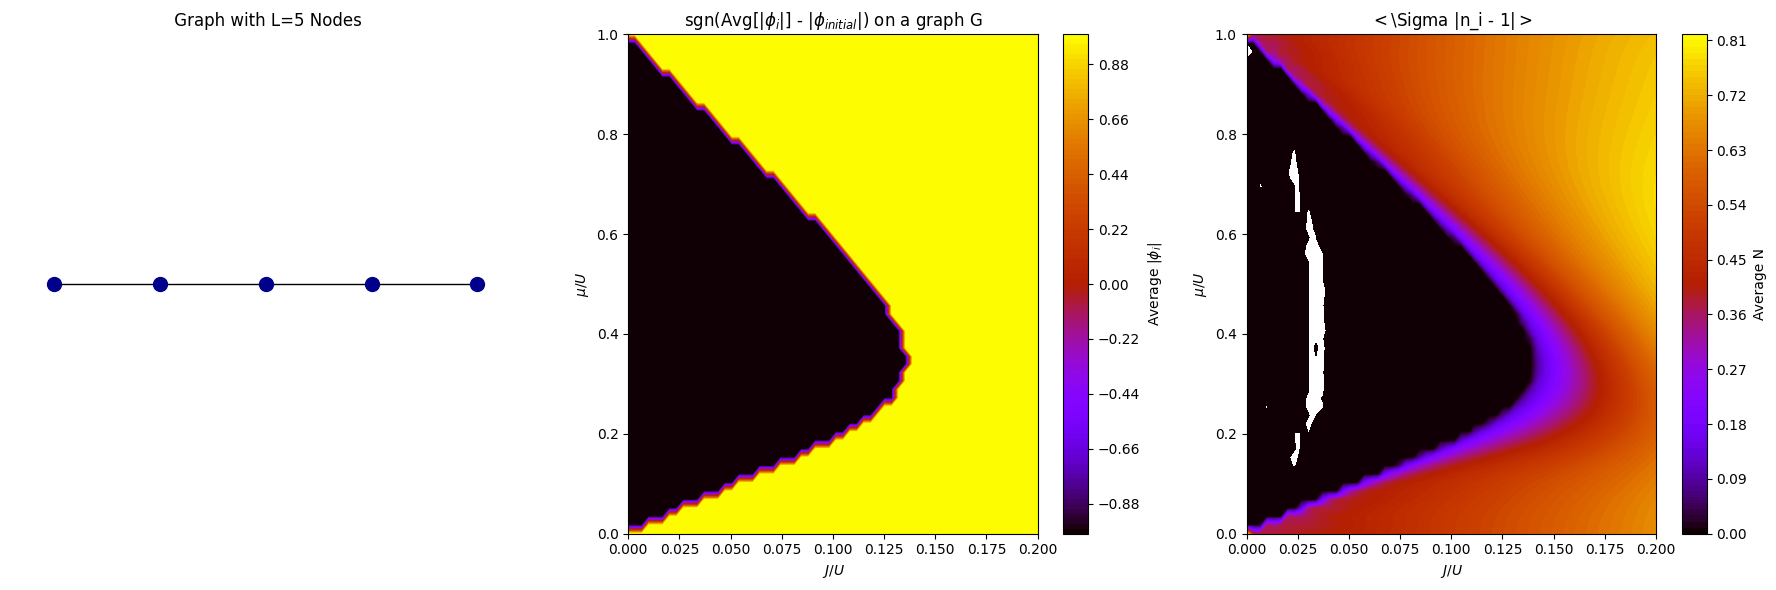

In [14]:
l = 5
G,pos = gridGraph((1,l))
#dMat = np.load("./hyperAdMat/hyp37size2center.npy")
#G = nx.from_numpy_array(adMat)
#pos = nx.spring_layout(G)

targetNiu = 2
target_node = l//2
point_number = 60
point_number_J = point_number
max_iterations = 50
J_min = 0.0
max_J = 0.4/targetNiu

fp = "./overlapData/"
name = "1d_test"

max_loc_flucs=2
N_minus=-5
N_plus=5
max_global_flucs=5
import os
os.makedirs(fp, exist_ok=True)

parameters_info = f"""
Parameters used:
----------------
targetNiu: {targetNiu}
target_node: {target_node}
point_number: {point_number}
point_number_J: {point_number_J}
max_iterations: {max_iterations}
J_min: {J_min}
max_J: {max_J}
max_loc_flucs: {max_loc_flucs}
max_global_flucs: {max_global_flucs}
N_minus: {N_minus}
N_plus: {N_plus}
"""#check last parameters

with open(fp + name + "_params.txt", "w") as f:
    f.write(parameters_info)


diag=phaseDiagramDataParallel_H_tuple(G,target_node,targetNiu,point_number=point_number,point_number_J=point_number ,max_iterations=max_iterations,
                                        max_J = max_J, max_loc_flucs=max_loc_flucs, max_global_flucs=max_global_flucs, N_minus=N_minus,N_plus=N_plus, save_csv_path=fp+name)

np.save(fp+name,diag[-1])
phaseDiagramPlotter(diag,G,pos,binarize=True,filepath=fp+name)

Starting calculation for 60 points of a size 9 sites
Basis of size 6211 generated in 0.0521 s
H of size 6211 generated in 0.4835 s


Processing:   0%|          | 0/60 [00:00<?, ?it/s]

Calculation completed in 537.88 seconds


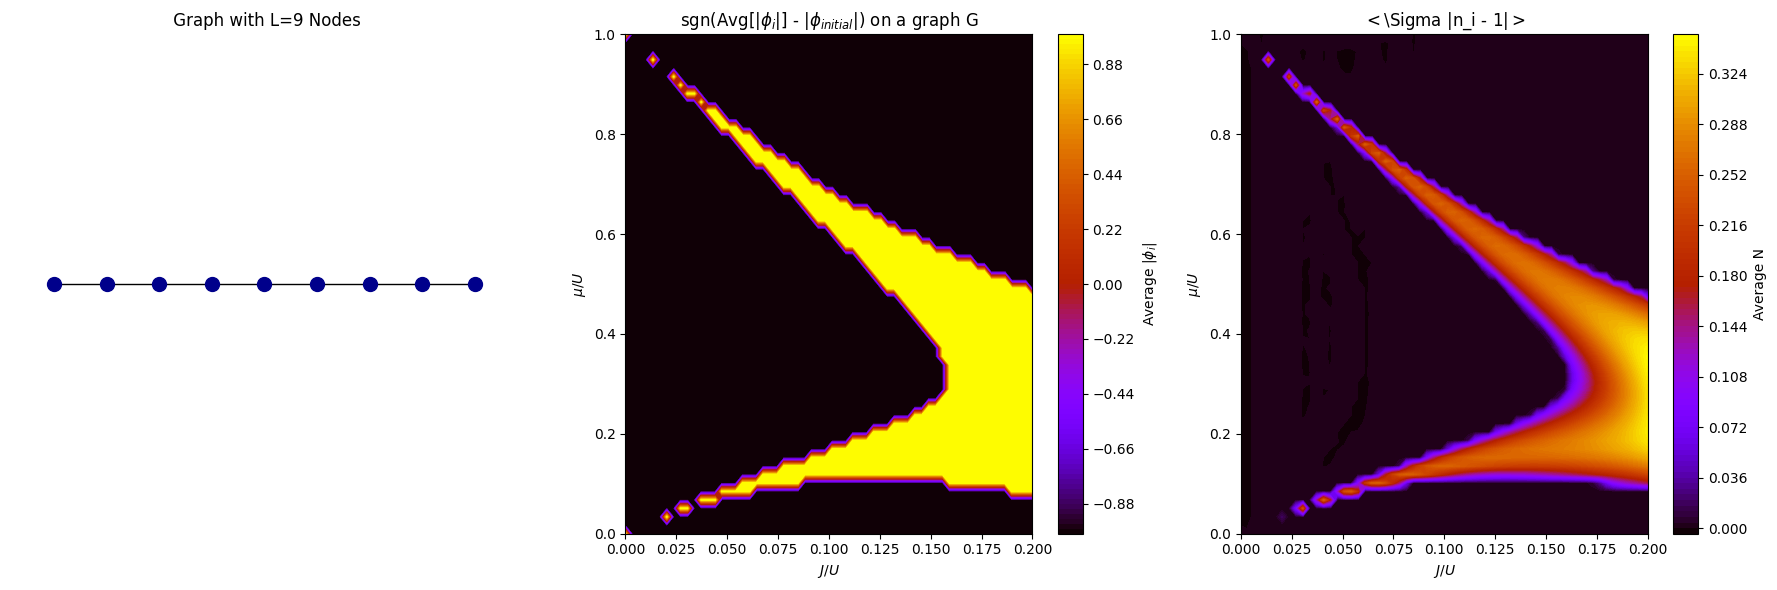

In [20]:
l = 9
G,pos = gridGraph((1,l))
#dMat = np.load("./hyperAdMat/hyp37size2center.npy")
#G = nx.from_numpy_array(adMat)
#pos = nx.spring_layout(G)

targetNiu = 2
target_node = l//2
point_number = 60
point_number_J = point_number
max_iterations = 50
J_min = 0.0
max_J = 0.4/targetNiu

fp = "./overlapData/"
name = "1d_l9_small_basis_more_iter"

max_loc_flucs=2
N_minus=-1
N_plus=1
max_global_flucs=5
import os
os.makedirs(fp, exist_ok=True)

parameters_info = f"""
Parameters used:
----------------
targetNiu: {targetNiu}
target_node: {target_node}
point_number: {point_number}
point_number_J: {point_number_J}
max_iterations: {max_iterations}
J_min: {J_min}
max_J: {max_J}
max_loc_flucs: {max_loc_flucs}
max_global_flucs: {max_global_flucs}
N_minus: {N_minus}
N_plus: {N_plus}
"""#check last parameters

with open(fp + name + "_params.txt", "w") as f:
    f.write(parameters_info)


diag=phaseDiagramDataParallel_H_tuple(G,target_node,targetNiu,point_number=point_number,point_number_J=point_number ,max_iterations=max_iterations,
                                        max_J = max_J, max_loc_flucs=max_loc_flucs, max_global_flucs=max_global_flucs, N_minus=N_minus,N_plus=N_plus, save_csv_path=fp+name)

np.save(fp+name,diag[-1])
phaseDiagramPlotter(diag,G,pos,binarize=True,filepath=fp+name)

Starting calculation for 60 points of a size 16 sites
Basis of size 219689 generated in 4.1112 s
H of size 219689 generated in 40.7535 s


Processing:   0%|          | 0/15 [00:00<?, ?it/s]

Calculation completed in 1438.51 seconds


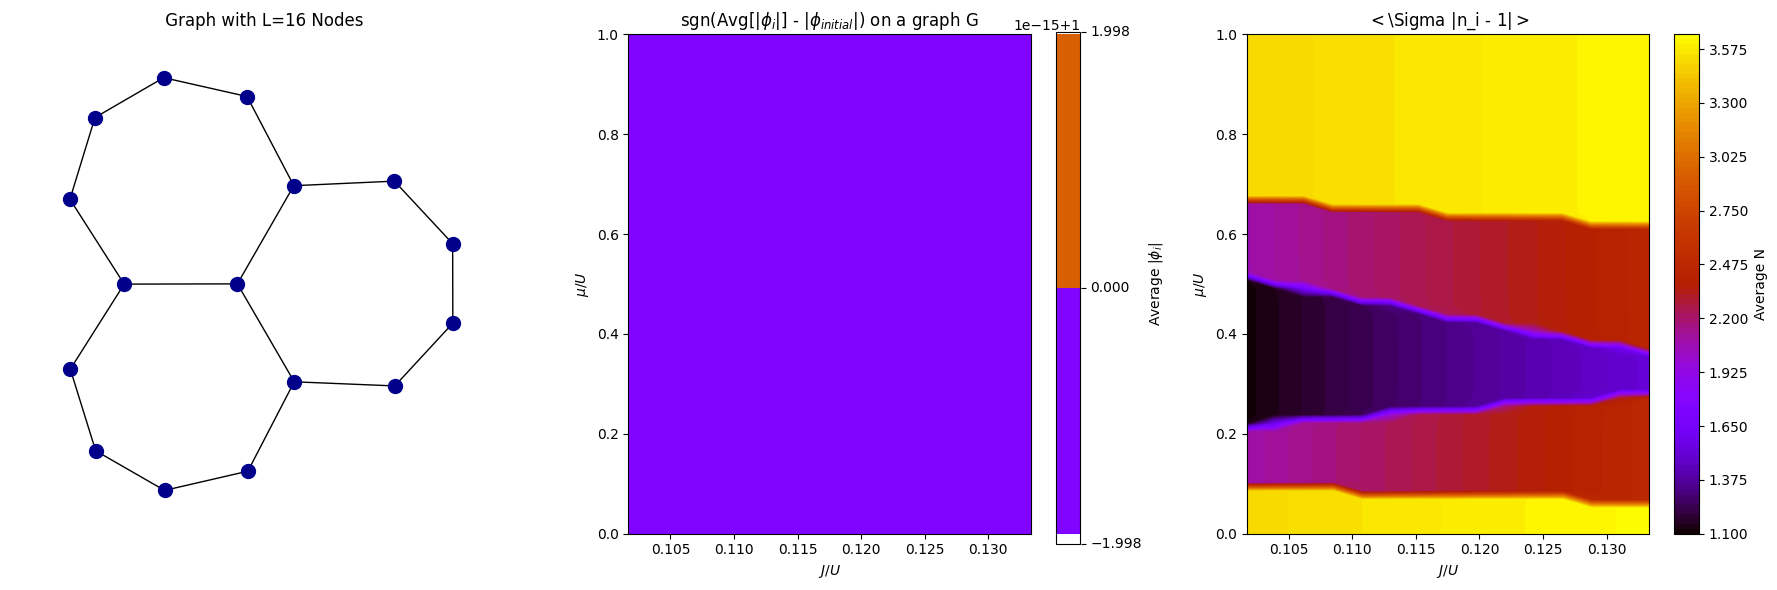

In [21]:

G,pos = hypGraph(7,3,2,vertexCenter=True)
#dMat = np.load("./hyperAdMat/hyp37size2center.npy")
#G = nx.from_numpy_array(adMat)
#pos = nx.spring_layout(G)

targetNiu = 3
target_node = 0#
point_number = 60
point_number_J = point_number
max_iterations = 1
J_min = 0.0
max_J = 0.4/targetNiu

fp = "./overlapData/"
name = "hyp73_size2_center_v2"

max_loc_flucs=2
N_minus=-3
N_plus=3

import os
os.makedirs(fp, exist_ok=True)

parameters_info = f"""
Parameters used:
----------------
targetNiu: {targetNiu}
target_node: {target_node}
point_number: {point_number}
point_number_J: {point_number_J}
max_iterations: {max_iterations}
J_min: {J_min}
max_J: {max_J}
max_loc_flucs: {max_loc_flucs}
N_minus: {N_minus}
N_plus: {N_plus}
"""#check last parameters

with open(fp + name + "_params.txt", "w") as f:
    f.write(parameters_info)


diag=phaseDiagramDataParallel_H_tuple(G,target_node,targetNiu,point_number=point_number,point_number_J=15 ,max_iterations=max_iterations,
                                      J_min=0.1016949152542373, max_J = max_J, max_loc_flucs=max_loc_flucs, N_minus=N_minus,N_plus=N_plus, save_csv_path=fp+name)

np.save(fp+name,diag[-1])
phaseDiagramPlotter(diag,G,pos,binarize=True,filepath=fp+name)

In [ ]:
l = 16
G,pos = gridGraph((1,l))
G,pos = hypGraph(7,3,2,vertexCenter=True)
diag=phaseDiagramDataParallel_H_tuple(G,0*l//2,2,point_number=20,max_iterations=1,max_J=0.3,N_minus=-3,N_plus=3,max_loc_flucs=2,max_global_flucs=5, 
                                      parallel=True,save_csv_path='test')
phaseDiagramPlotter(diag,G,pos,binarize=True)

Starting calculation for 20 points of a size 16 sites
Basis of size 219689 generated in 3.9268 s
H of size 219689 generated in 27.8883 s


Processing:   0%|          | 0/20 [00:00<?, ?it/s]

Starting calculation for 30 points of a size 7 sites
Basis of size 4026 generated in 0.0649 s
H of size 4026 generated in 0.2846 s


Processing:   0%|          | 0/30 [00:00<?, ?it/s]

Calculation completed in 14.51 seconds


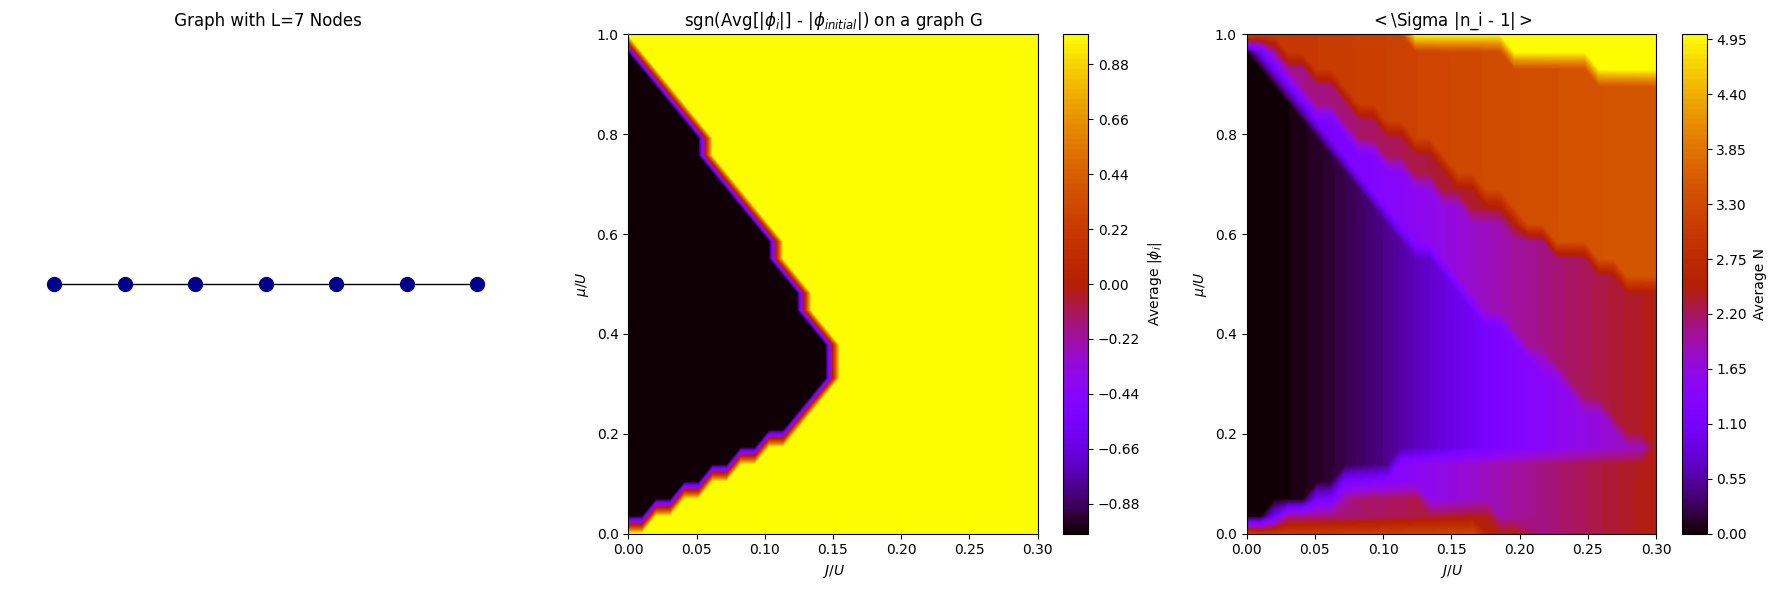

In [ ]:
l = 9
G,pos = gridGraph((1,l))

diag=phaseDiagramDataParallel_H_tuple(G,l//2,2,point_number=30,max_iterations=1,max_J=0.3,N_minus=-5,N_plus=5,max_loc_flucs=3,max_global_flucs=5, 
                                      parallel=True,save_csv_path='test')
phaseDiagramPlotter(diag,G,pos,binarize=True)

Starting calculation for 30 points of a size 7 sites
Basis of size 4026 generated in 0.0518 s
H of size 4026 generated in 0.3850 s


Processing:   0%|          | 0/30 [00:00<?, ?it/s]

Calculation completed in 14.03 seconds


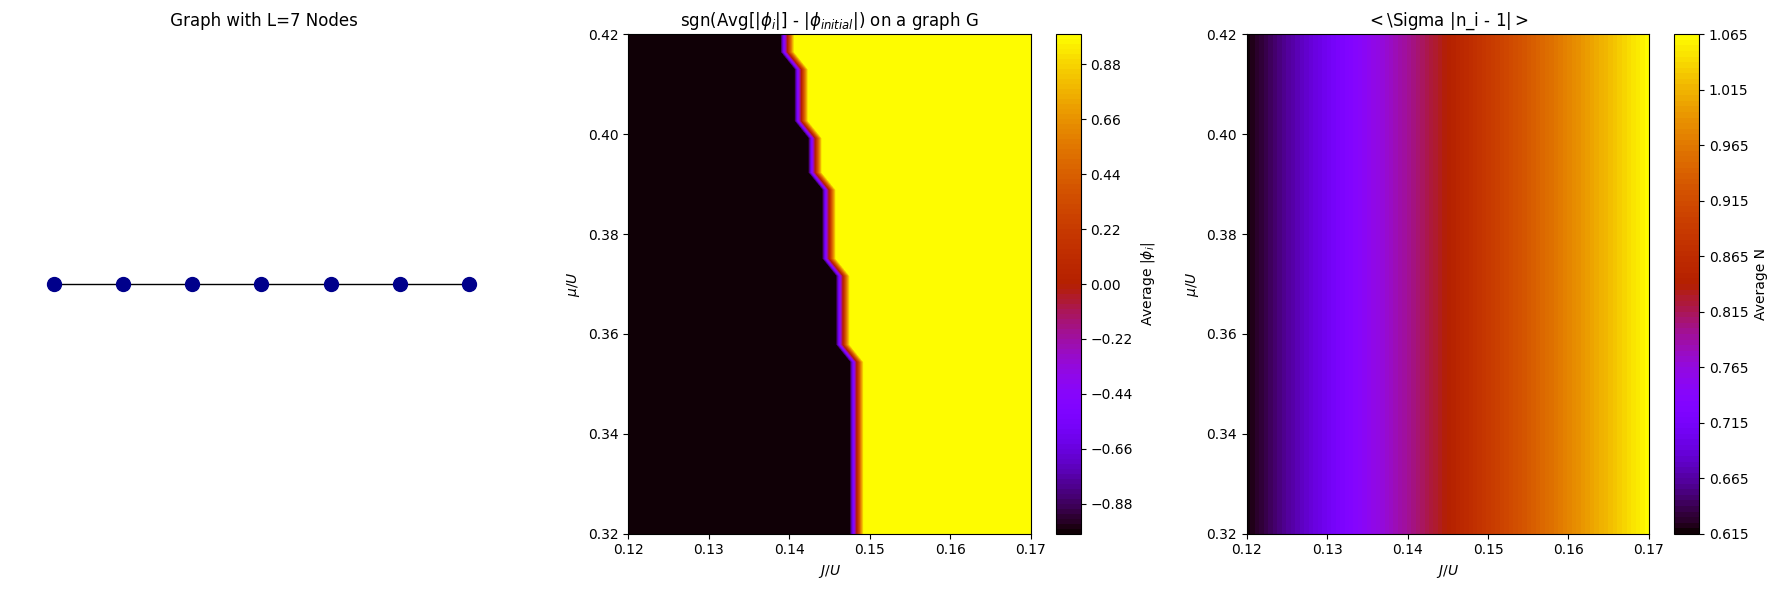

In [36]:
l = 7
G,pos = gridGraph((1,l))

diag=phaseDiagramDataParallel_H_tuple(G,l//2,2,point_number=30,max_iterations=1,max_J=0.17,N_minus=-5,N_plus=5,max_loc_flucs=3,max_global_flucs=5, 
                                      parallel=True, J_min=0.12,mu_min=0.32,mu_max=0.42,save_csv_path='test')
phaseDiagramPlotter(diag,G,pos,binarize=True)